Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import seaborn as sns
#seed
seed = np.random.seed(55)

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train/")
data_dir_test = pathlib.Path("./Test")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 25
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)##todo

Found 2239 files belonging to 9 classes.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)##todo

Found 118 files belonging to 9 classes.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = np.array(train_ds.class_names)
print(class_names)

['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'seborrheic keratosis'
 'squamous cell carcinoma' 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

## Keras.preprocessing
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


# Get a generator 
#data_gen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)

# Make data generator for training and validation data
train_data_gen = image_generator.flow_from_directory(data_dir_train, 
                                              target_size=(img_height, img_width), 
                                              class_mode="categorical", 
                                              shuffle=True, 
                                              batch_size=batch_size)

Found 2239 images belonging to 9 classes.


In [11]:
image_batch, label_batch = next(iter(train_data_gen))

In [12]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        # plt.imshow(cv2.cvtColor(image_batch[n], cv2.COLOR_BGR2RGB))
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

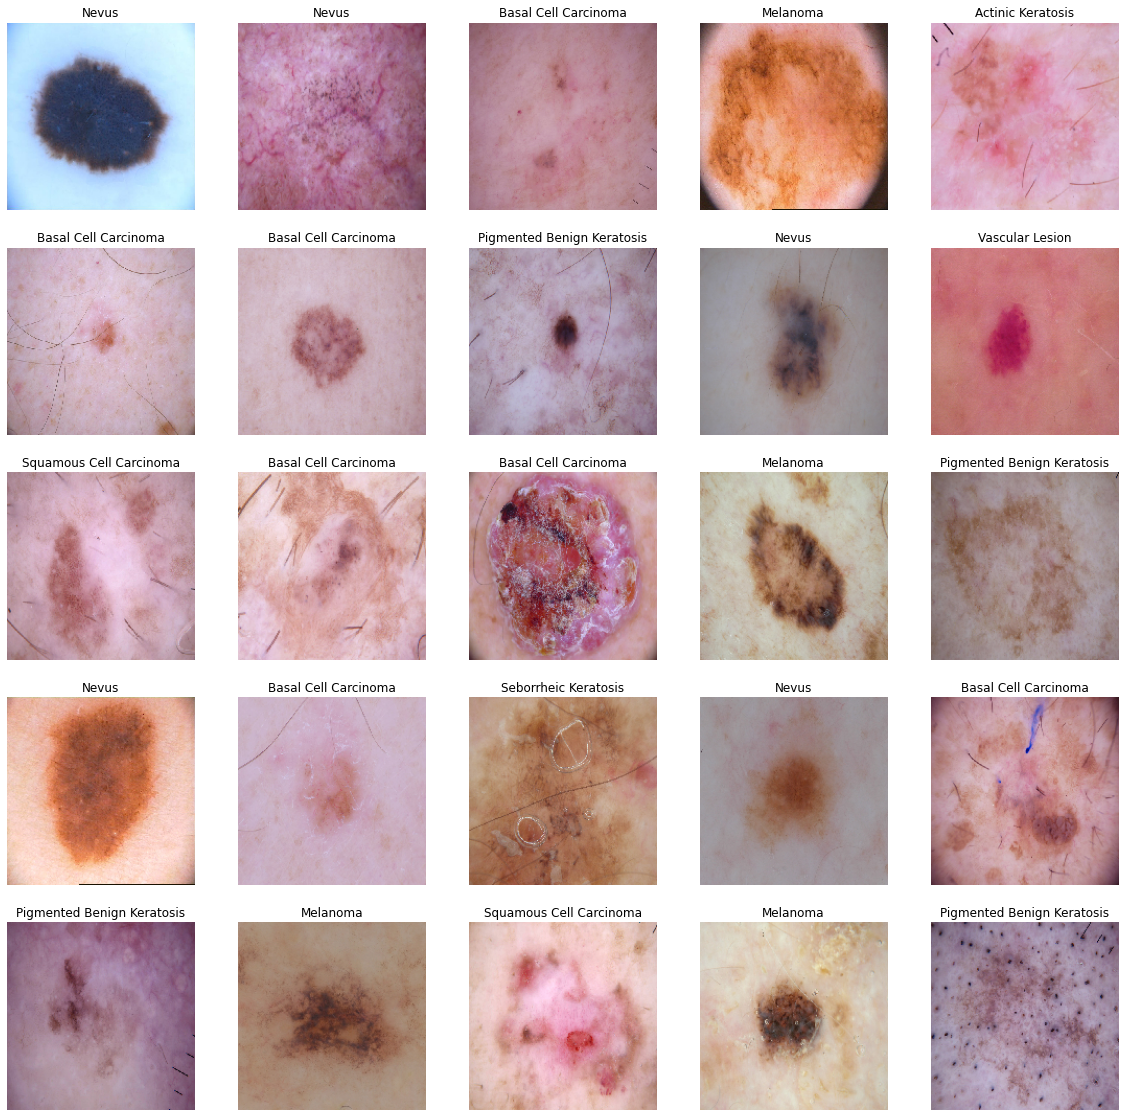

In [13]:
show_batch(image_batch, label_batch)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
90/90 [==============================] - 90s 640ms/step - loss: 2.1388 - accuracy: 0.2290 - val_loss: 2.2121 - val_accuracy: 0.2373
Epoch 2/20
90/90 [==============================] - 47s 520ms/step - loss: 1.6733 - accuracy: 0.3869 - val_loss: 2.4312 - val_accuracy: 0.2712
Epoch 3/20
90/90 [==============================] - 45s 501ms/step - loss: 1.4128 - accuracy: 0.5146 - val_loss: 2.1622 - val_accuracy: 0.3136
Epoch 4/20
90/90 [==============================] - 48s 529ms/step - loss: 1.3431 - accuracy: 0.5342 - val_loss: 2.1874 - val_accuracy: 0.2797
Epoch 5/20
90/90 [==============================] - 45s 495ms/step - loss: 1.2257 - accuracy: 0.5832 - val_loss: 2.9342 - val_accuracy: 0.2966
Epoch 6/20
90/90 [==============================] - 44s 493ms/step - loss: 1.1473 - accuracy: 0.5903 - val_loss: 2.3157 - val_accuracy: 0.3136
Epoch 7/20
90/90 [==============================] - 45s 504ms/step - loss: 1.0844 - accuracy: 0.6160 - val_loss: 3.0036 - val_accuracy: 0.2797

### Visualizing training results

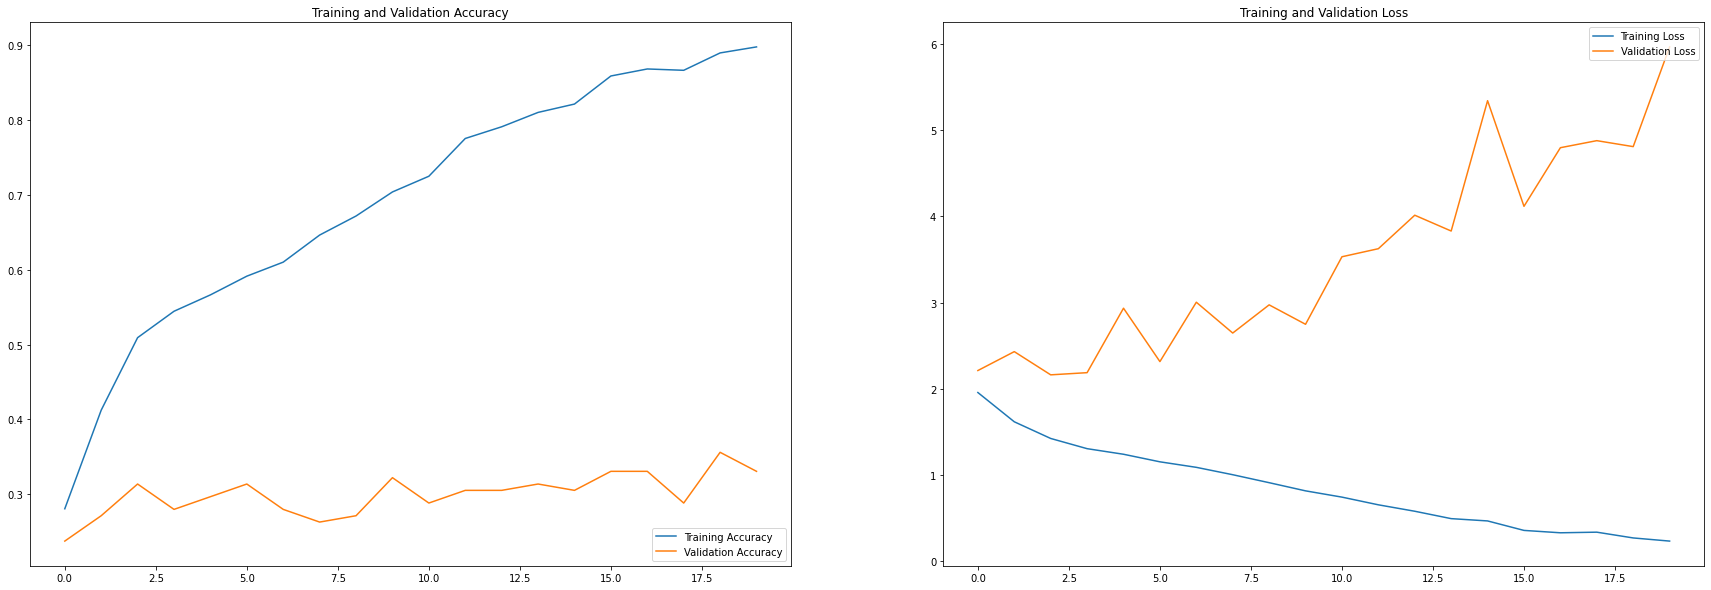

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### Training accuracy and validation accuracy are off by large margin and the model has achieved only around 30% accuracy on the validation set and huge overfiting of the data in validationset

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


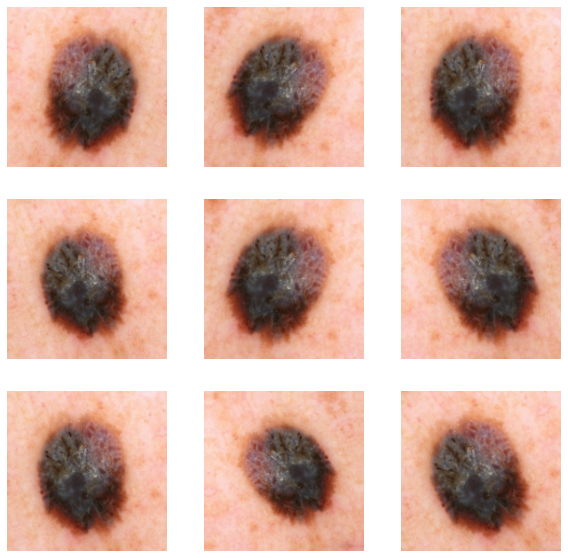

In [22]:
#augumented data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model_2= Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [24]:
## Your code goes here
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/20
90/90 [==============================] - 53s 576ms/step - loss: 2.6063 - accuracy: 0.1876 - val_loss: 2.2346 - val_accuracy: 0.1356
Epoch 2/20
90/90 [==============================] - 52s 578ms/step - loss: 1.8876 - accuracy: 0.3475 - val_loss: 2.3065 - val_accuracy: 0.3136
Epoch 3/20
90/90 [==============================] - 52s 583ms/step - loss: 1.5873 - accuracy: 0.4622 - val_loss: 2.1629 - val_accuracy: 0.3051
Epoch 4/20
90/90 [==============================] - 56s 619ms/step - loss: 1.5016 - accuracy: 0.4793 - val_loss: 2.3789 - val_accuracy: 0.2627
Epoch 5/20
90/90 [==============================] - 53s 591ms/step - loss: 1.5309 - accuracy: 0.4650 - val_loss: 2.4767 - val_accuracy: 0.3051
Epoch 6/20
90/90 [==============================] - 53s 585ms/step - loss: 1.4415 - accuracy: 0.4970 - val_loss: 2.1291 - val_accuracy: 0.3390
Epoch 7/20
90/90 [==============================] - 53s 585ms/step - loss: 1.3455 - accuracy: 0.5220 - val_loss: 2.2752 - val_accuracy: 0.3305

### Visualizing the results

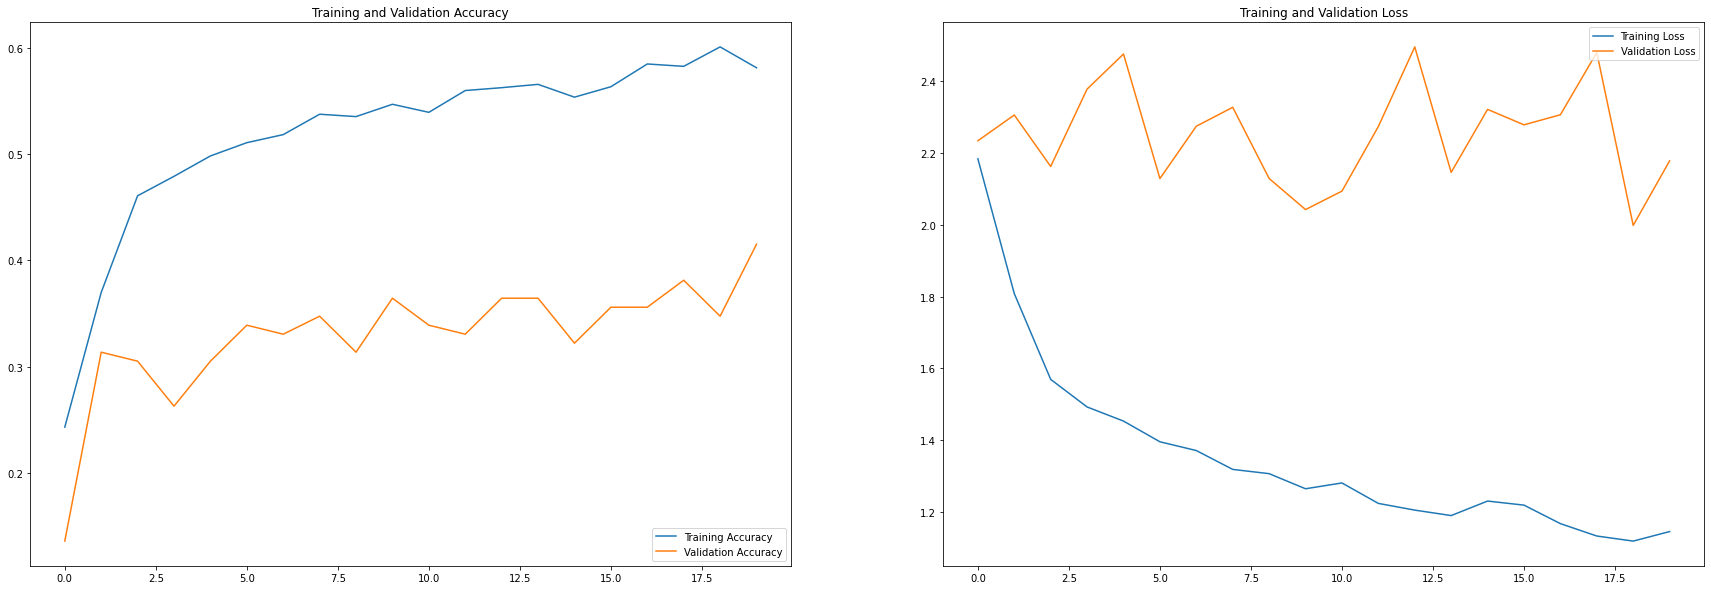

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run? 

`there is a slight imporovement but, not as expected`

In [49]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [50]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Train/melanoma/ISIC_0010550.jpg,melanoma
1,Train/melanoma/ISIC_0011128.jpg,melanoma
2,Train/melanoma/ISIC_0010587.jpg,melanoma
3,Train/melanoma/ISIC_0010034.jpg,melanoma
4,Train/melanoma/ISIC_0000555.jpg,melanoma
...,...,...
2234,Train/dermatofibroma/ISIC_0033554.jpg,dermatofibroma
2235,Train/dermatofibroma/ISIC_0027044.jpg,dermatofibroma
2236,Train/dermatofibroma/ISIC_0033780.jpg,dermatofibroma
2237,Train/dermatofibroma/ISIC_0033810.jpg,dermatofibroma


Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


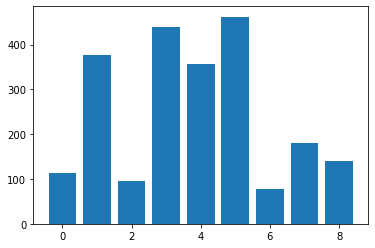

In [51]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

From this plot we can see that this data set is imbalnced one
#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
class_names

array(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
       'melanoma', 'nevus', 'pigmented benign keratosis',
       'seborrheic keratosis', 'squamous cell carcinoma',
       'vascular lesion'], dtype='<U26')

In [32]:
#path_to_training_dataset= "../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
import Augmentor
path_to_training_dataset= './Train/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to ./Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC60BF95B80>: 100%|██████████| 500/500 [00:12<00:00, 39.25 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to ./Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC69CE5F280>: 100%|██████████| 500/500 [00:15<00:00, 31.45 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC60BDEB190>:   0%|          | 1/500 [00:00<00:53,  9.32 Samples/s]

Initialised with 95 image(s) found.
Output directory set to ./Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC60C2966A0>: 100%|██████████| 500/500 [00:15<00:00, 32.57 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to ./Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7FC60C25CAF0>: 100%|██████████| 500/500 [01:13<00:00,  6.76 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to ./Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FC60CF86F40>: 100%|██████████| 500/500 [01:01<00:00,  8.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to ./Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC69CE68670>: 100%|██████████| 500/500 [00:15<00:00, 31.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to ./Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC60CF80280>: 100%|██████████| 500/500 [00:36<00:00, 13.81 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to ./Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC60C21E5E0>: 100%|██████████| 500/500 [00:15<00:00, 32.96 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC60C2790A0>:   0%|          | 1/500 [00:00<01:04,  7.71 Samples/s]                  

Initialised with 139 image(s) found.
Output directory set to ./Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC60BB288B0>: 100%|██████████| 500/500 [00:15<00:00, 32.83 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))] # need to add glob.glob
path_list

['Train/melanoma/output/melanoma_original_ISIC_0010143.jpg_714eada2-ea76-4825-8fe1-255d4523d26c.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010750.jpg_b2e5aadf-aa14-4bd5-8735-9bfa27285bd6.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010749.jpg_71748fd5-7d38-479d-a588-b11cb90a6448.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010119.jpg_18480b6c-25b1-499c-b5b4-6b56fdc8194c.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010729.jpg_9568e429-ea2c-4762-a956-e8468f8706ae.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010799.jpg_739eb493-bc90-4d8c-8b6d-0b3b362626b8.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010217.jpg_d8fd9ddb-5374-4be1-b520-82757d181eea.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010426.jpg_d7b1d4ba-5cea-4a56-94a2-a1b4e54967cd.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000526.jpg_b5534f23-5908-452e-abac-d7282a8a881f.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010278.jpg_76aad60f-5311-4318-a6ca

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [43]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
#dataframe_dict_new

In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)


In [54]:
#path_list.count()
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [55]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [59]:
## your code goes here
model_3= Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
## your code goes here
## Your code goes here
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [61]:
epochs = 20
## Your code goes here, use 30 epochs.
history = history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/20
169/169 [==============================] - 260s 2s/step - loss: 1.2094 - accuracy: 0.5338 - val_loss: 1.1106 - val_accuracy: 0.5805
Epoch 2/20
169/169 [==============================] - 240s 1s/step - loss: 1.1422 - accuracy: 0.5586 - val_loss: 1.1166 - val_accuracy: 0.5828
Epoch 3/20
169/169 [==============================] - 239s 1s/step - loss: 1.1015 - accuracy: 0.5770 - val_loss: 0.9951 - val_accuracy: 0.6036
Epoch 4/20
169/169 [==============================] - 242s 1s/step - loss: 1.0630 - accuracy: 0.5886 - val_loss: 1.0729 - val_accuracy: 0.5895
Epoch 5/20
169/169 [==============================] - 242s 1s/step - loss: 1.0219 - accuracy: 0.6122 - val_loss: 0.9938 - val_accuracy: 0.6184
Epoch 6/20
169/169 [==============================] - 237s 1s/step - loss: 1.0128 - accuracy: 0.6098 - val_loss: 1.0360 - val_accuracy: 0.6169
Epoch 7/20
169/169 [==============================] - 215s 1s/step - loss: 0.9943 - accuracy: 0.6296 - val_loss: 0.9628 - val_accuracy: 0.6414

#### **Todo:**  Visualize the model results

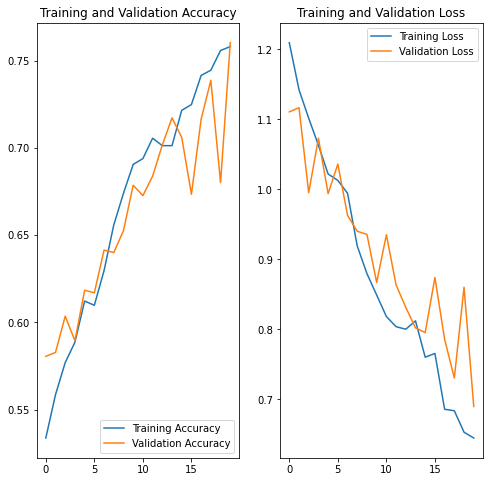

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()